<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:200%;
           font-family:Arial;letter-spacing:0.5px">

<p width = 20%, style="padding: 10px;
              color:white;">
Feature Engineering: Scaling, Polynomials, and Interactions
              
</p>
</div>

Data Science Cohort Live NYC Oct 2022
<p>Phase 2: Topic 20</p>
<br>
<br>

<div align = "right">
<img src="Images/flatiron-school-logo.png" align = "right" width="200"/>
</div>
    
    

#### Feature Engineering: Transforming input data
- Input in form that the better conforms to structure of input-output relationship.
- Model interactions between features.

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
noise = norm.rvs(scale = 16, size = 400)
x = np.linspace(-7,7, 400) + 300
y = 3*(x-300)**2  + 4*(x-300) + 100 + noise
tempyield_data = pd.DataFrame({'Temp': x, 'Yield': y})

- Target may not depend linearly on feature set.
- I.e. cant approximate well by a hyperplane.

In [41]:
%%capture yieldvtemp
sns.set_context('talk')
fig, ax = plt.subplots()
sns.scatterplot(y ='Yield', x = 'Temp', data = tempyield_data, ax = ax)
ax.set_title('Yield vs. Temperature')
plt.show()

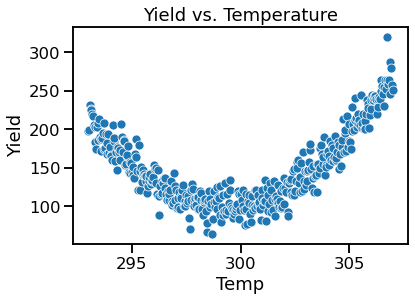

In [42]:
yieldvtemp()

Fitting yield to a model simply linear in temperature might be considered silly. 

What kind of dependence might we try?

In [43]:
tempyield_data.head()

,Temp,Yield
0,293.000000,197.549949
1,293.035088,199.152132
2,293.070175,231.182124
3,293.105263,226.594788
4,293.140351,224.971136


Perform a regression:
$$ Y = \beta_2T^2 + \beta_1T + \beta_0  $$

*Note*: this is still a model **linear** in coefficients. 

Construct another column that is $T^2$.

In [44]:
tempyield_data['Temp_squared'] = tempyield_data['Temp']**2
tempyield_data.head()

,Temp,Yield,Temp_squared
0,293.000000,197.549949,85849.000000
1,293.035088,199.152132,85869.562635
2,293.070175,231.182124,85890.127732
3,293.105263,226.594788,85910.695291
4,293.140351,224.971136,85931.265312


Linear regression of Yield on $T$ and $T^2$.

Doing a regression just on T. Silly but lets do it anyway to see:

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [46]:
X = tempyield_data['Temp']
y = tempyield_data['Yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

lr_simple = LinearRegression()
lr_simple.fit(X_train.values.reshape(-1,1), y_train)

LinearRegression()

In [47]:
print(lr_simple.coef_, lr_simple.intercept_)

[3.944591] -1037.507132820292


In [48]:
lr_simple.score(X_train.values.reshape(-1,1),
                y_train)

0.10906220830483404

In [49]:
y_pred = lr_simple.predict(X_test.values.reshape(-1,1))
mean_absolute_error(y_pred, y_test)

38.79667224626288

But saying there is no relation between temperature and yield is obviously a mistake!

Regression on $T$ and $T^2$.

In [50]:
X_poly = tempyield_data[['Temp', 'Temp_squared']]
y = tempyield_data['Yield']

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.3, random_state = 42)

lr_poly = LinearRegression()
lr_poly.fit(X_train, y_train)

LinearRegression()

In [51]:
print(lr_poly.coef_, lr_poly.intercept_)

[-1753.56852731     2.92909344] 262552.91904657456


In [52]:
lr_poly.score(X_train, y_train)

0.9014494992076981

In [53]:
y_pred_poly = lr_poly.predict(X_test)
mean_absolute_error(y_pred_poly, y_test)

11.748284220557911

Let's visualize the difference in predictions:

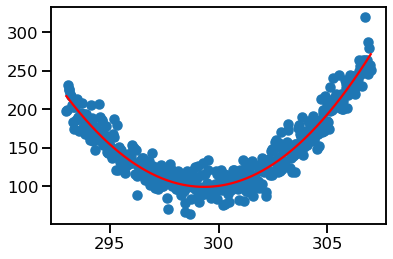

In [54]:
beta_1, beta_2 = lr_poly.coef_
beta_0 = lr_poly.intercept_

poly_pred = beta_2*X**2 + beta_1*X + beta_0

fig, ax = plt.subplots()
ax.plot(X, poly_pred, c ='r')
ax.scatter(X, y)
plt.show()

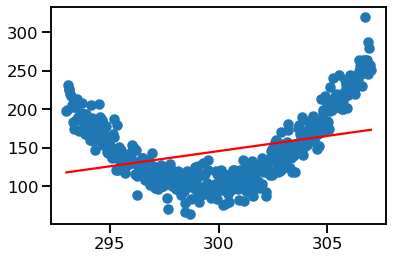

In [55]:
beta_1 = lr_simple.coef_[0]
beta_0 = lr_simple.intercept_

lin_pred = beta_1*X + beta_0

fig, ax = plt.subplots()
ax.plot(X, lin_pred, c ='r')
ax.scatter(X, y)
plt.show()

#### More generally

Target depend on feature with higher order polynomial. Procedure would be same.

$$ Y = \beta_0 + \beta_1 x + \beta_2 x^2 + ... + \beta_n x^n $$

Again:
- Construct feature columns for each power of x.
- Fit $\beta_i$ using linear regression.

#### Using scikit-learn: PolynomialFeatures with a single feature

- With single feature is easy/fast way to construct these features at higher power.
- Again, main advantage: can be used in a pipeline.

In [56]:
from sklearn.preprocessing import PolynomialFeatures

PolynomialFeatures()
- Takes arguments for highest order of polynomial
- Can chose to include zeroth power term for fitting bias (useful for statsmodels)

In [57]:
pf = PolynomialFeatures(degree = 2, include_bias = False ) #false for sklearn 
X_to_second = pf.fit_transform(X.values.reshape(-1,1))
X_to_second[0:10]

array([[  293.        , 85849.        ],
       [  293.03508772, 85869.56263466],
       [  293.07017544, 85890.12773161],
       [  293.10526316, 85910.69529086],
       [  293.14035088, 85931.2653124 ],
       [  293.1754386 , 85951.83779625],
       [  293.21052632, 85972.41274238],
       [  293.24561404, 85992.99015082],
       [  293.28070175, 86013.57002155],
       [  293.31578947, 86034.15235457]])

And fitting is exactly the same as before.

#### PolynomialFeatures() with multiple features.

In [58]:
sales_df = pd.read_csv('Data/advertising.csv').drop(columns = ['Unnamed: 0'])
sales_df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [59]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


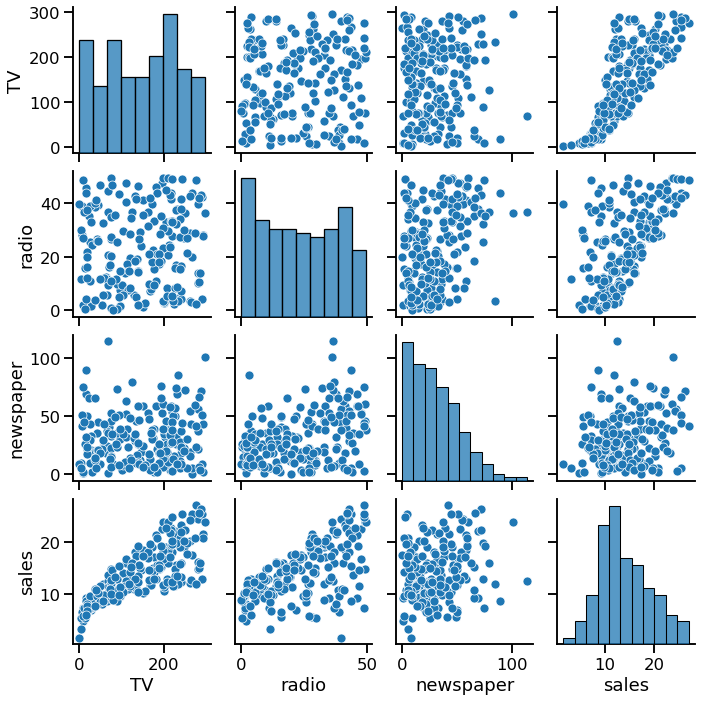

In [60]:
ax = sns.pairplot(sales_df)

<AxesSubplot:>

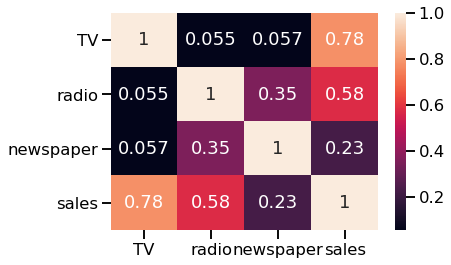

In [61]:
sns.heatmap(sales_df.corr(), annot = True)

Maybe want to model interactions

Recall that $$ Cov(Radio, TV) \rightarrow Radio\times TV $$

Average of product encodes correlation between the two.

Using products of features as new features:

- Factors pairwise correlations of original features into prediction.

Model with linear terms and interactions:
$$ Sales = \beta_{TV} TV + \beta_{Radio} Radio + \beta_{Newspaper} Newspaper + \\ \beta^{int}_1 \Big( TV \times Radio \Big) + \beta^{int}_2 \Big( TV \times Newspaper \Big) + \beta^{int}_3 \Big(Radio \times Newspaper\Big) + \beta_0 $$

vs. model with just linear terms

$$ Sales = \beta_{TV} TV + \beta_{Radio} Radio + \beta_{Newspaper} Newspaper + \beta_0 $$

In [62]:
X = sales_df[['TV', 'radio', 'newspaper']]
y = sales_df['sales']

First conduct linear regression on the raw features:
- train test split
- then perform standardization

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

We could apply pandas .apply():
- very inconvenient when doing train test splits
- fitting parameters on train set
- applying trasformation based on those parameters to:
    - train
    - test

Scikit-learn has transformer object that standardizes columns:
- just for this purpose on train/test

In [64]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Now extract means and standard deviations for each column:
- .fit() method
Then apply transformartion to both train and test:
- .transform() method
    

In [65]:
ss.fit(X_train)
X_standardized_train = ss.transform(X_train)
X_standardized_test = ss.transform(X_test)

In [66]:
X_standardized_train.mean(axis = 0)

array([ 1.21331516e-16, -1.45915026e-16,  7.29575130e-17])

In [67]:
X_standardized_train.std(axis = 0)

array([1., 1., 1.])

In [68]:
X_standardized_test.mean(axis = 0)

array([0.19824393, 0.14420602, 0.14123086])

In [69]:
X_standardized_test.std(axis = 0)

array([0.99516987, 0.94902482, 1.05277524])

Now define and fit the model on the train set using the standardized training features:
- get $R^2$

In [70]:
lr_raw = LinearRegression()
lr_raw.fit(X_standardized_train, y_train)
lr_raw.score(X_standardized_train, y_train)

0.8900468822460821

In [71]:
pd.Series(lr_raw.coef_,
          index = X.columns) 

TV           3.821954
radio        2.780763
newspaper   -0.098907
dtype: float64

This jives with our expectations from EDA.

Evaluating on the test set:

In [72]:
y_pred = lr_raw.predict(X_standardized_test)
mean_absolute_error(y_pred, y_test)

1.263299576177008

Can we do better with Polynomial Features?
- Let's include the interaction terms!

PolynomialFeatures:
- has argument interaction_only = True/False.
- If true only takes interactions terms at highest order specified.

In [73]:
linear_withinteraction = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)

We've already made the train/test split:
- X_train, X_test, y_train, y_test

Fit PolynomialFeatures to train set, then transform both sets

In [78]:
linear_withinteraction.fit(X_train)
feat_names = pd.Series(linear_withinteraction.get_feature_names())
feat_names

0       x0
1       x1
2       x2
3    x0 x1
4    x0 x2
5    x1 x2
dtype: object

In [79]:
Xpolytrans_train = linear_withinteraction.transform(X_train)
Xpolytrans_test = linear_withinteraction.transform(X_test)

After pandafying our numpy array for train set:

In [89]:
map_dict = {'x0': 'TV', 'x1': 'Radio', 'x2': 'Newspaper'}
for key, value in map_dict.items():
    feat_names = feat_names.str.replace(key, value)
X_trans_df = pd.DataFrame(Xpolytrans_train ,columns = feat_names)

In [90]:
X_trans_df.head()

,TV,Radio,Newspaper,TV Radio,TV Newspaper,Radio Newspaper
0,175.1,22.5,31.5,3939.75,5515.65,708.75
1,218.4,27.7,53.4,6049.68,11662.56,1479.18
2,262.7,28.8,15.9,7565.76,4176.93,457.92
3,107.4,14.0,10.9,1503.60,1170.66,152.60
4,8.6,2.1,1.0,18.06,8.60,2.10


Looks good. Let's standardize the variables and analyze the weights of the factors and their interactions.
- Again: apply the standardscaler to the train set with interaction and transform test

In [91]:
# standardizes each column in feature matrix. Scikit-learn has a transformer for this.
ss = StandardScaler() # object with does the standardization
X_trans_train = ss.fit_transform(Xpolytrans_train) # fit and transforms new polynomial feature matrix
X_trans_test = ss.transform(Xpolytrans_test) # uses fit parameters from train set to standardize test set as well

Getting $R^2$ and coefficients for our standardized linear model with interactions:

In [92]:
lr_poly_scaled = LinearRegression()
lr_poly_scaled.fit(X_trans_train, y_train)

# gets R^2 value for train set
lr_poly_scaled.score(X_trans_train, y_train)

0.9676644952712022

In [93]:
pd.Series(lr_poly_scaled.coef_,
          index = X_trans_df.columns)

TV                 1.622661
Radio              0.227854
Newspaper          0.330744
TV Radio           3.854327
TV Newspaper      -0.350744
Radio Newspaper   -0.033720
dtype: float64

In [94]:
y_pred_interactions = lr_poly_scaled.predict(X_trans_test)
y_pred_interactions

array([19.26409178, 21.60216593, 12.21333843, 22.10434846,  7.78089854,
       13.47108354, 25.3313465 , 11.98946233, 17.7116241 , 14.59217709,
       12.03503351, 16.70553414, 15.47848882, 11.16745042, 25.09671852,
       16.06764584, 11.2267548 , 21.26603706, 13.42699808, 18.44428514,
       15.38144471, 25.84651811, 16.18486292, 15.06824377,  9.01070228,
       12.07074161,  8.15354285, 26.21841281, 26.77798782, 22.03020993,
       12.7437761 , 12.87205707, 15.12441695,  9.08627495,  9.53843978,
       10.55043872, 14.30865115,  7.11940311,  8.106247  , 14.83631173,
       11.34623162, 12.00428567, 10.30958095, 17.00293398, 17.19880137,
        9.69978592, 22.43589954, 13.21165277,  7.60080774,  7.60261393,
        9.96055811, 17.55824693, 11.10194647, 12.67336911, 20.60435061,
       11.87133539, 10.74660722, 18.59285216, 15.77810298, 15.26153253])

A comparison on test error with a mode linear in the features vs including interaction terms:

In [95]:
mean_absolute_error(y_pred_interactions, y_test)

0.6529180205224537

The old model:

In [96]:
mean_absolute_error(y_pred, y_test)

1.263299576177008

Some words of advice:
- Adding interactions and higher order terms can be useful.
- But they can also add extra variables that can lead to overfitting or useless parameters.
- Be careful and use your judgment.

#### Also: interaction terms not always interpretable. But may lead to better predictions.

Takeaway:
- This is where EDA is really important:
    - Visualization
    - Descriptive statistics 
    - Correlation matrices
    - Playing with your data!
    
See what transformations and functional relations useful for model inference and prediction.